## Основные этапы реализации RBF-сети

### 1. Генерация центров (центроидов) с помощью K-Means
```python
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_centers)
kmeans.fit(X)
centers = kmeans.cluster_centers_
```
**Описание:**
- Используем K-Means для нахождения центров кластеров в данных.
- Эти центры будут использоваться в качестве центроидов RBF-нейронов.

---

### 2. Выбор радиуса (ширины) гауссовой функции
```python
import numpy as np

def gaussian_rbf(x, c, beta):
    return np.exp(-beta * np.linalg.norm(x - c) ** 2)
```
**Описание:**
- Гауссова функция определяет вклад каждого RBF-нейрона.
- `beta` контролирует ширину функции (чем больше значение, тем уже гауссиан).

---

### 3. Расчет выходов RBF-слоя
```python
def calculate_interpolation_matrix(X, centers, beta):
    G = np.zeros((X.shape[0], len(centers)))
    for i, x in enumerate(X):
        for j, c in enumerate(centers):
            G[i, j] = gaussian_rbf(x, c, beta)
    return G
```
**Описание:**
- Заполняем матрицу интерполяции, применяя гауссову функцию ко всем данным.
- Каждая строка матрицы соответствует входному объекту, а столбец — значению RBF-функции.

---

### 4. Линейная модель выхода (метод наименьших квадратов)
```python
from numpy.linalg import pinv

def train_rbf_network(X, y, centers, beta):
    G = calculate_interpolation_matrix(X, centers, beta)
    weights = pinv(G).dot(y)
    return weights
```
**Описание:**
- Используем метод наименьших квадратов (псевдообратную матрицу) для нахождения весов.
- Позволяет минимизировать ошибку при аппроксимации целевой функции.

---

### 5. Предсказание на новых данных
```python
def predict_rbf_network(X_new, centers, beta, weights):
    G_new = calculate_interpolation_matrix(X_new, centers, beta)
    return G_new.dot(weights)
```
**Описание:**
- Вычисляем матрицу интерполяции для новых данных.
- Умножаем на найденные веса, чтобы получить предсказания.

---

### 6. Визуализация радиально-базисных функций
```python
import matplotlib.pyplot as plt

def plot_rbf_functions(X_range, centers, beta):
    plt.figure(figsize=(8, 6))
    for c in centers:
        rbf_values = np.exp(-beta * (X_range - c) ** 2)
        plt.plot(X_range, rbf_values, label=f'Center at {c[0]:.2f}')
    plt.title("RBF Functions")
    plt.xlabel("Input")
    plt.ylabel("RBF Value")
    plt.legend()
    plt.show()
```
**Описание:**
- Строит графики гауссовых функций, показывая вклад каждого RBF-нейрона.

---

### 7. Визуализация центров
```python
plt.scatter(X_train, y_train, label="Training Data")
plt.scatter(centers, np.zeros_like(centers), color='orange', label="Centers", marker='x')
plt.title("Centers identified by KMeans")
plt.legend()
plt.show()
```
**Описание:**
- Отображает центры, найденные K-Means, и данные для тренировки.

---

### 8. Ошибки и метрики (MSE и R²)
```python
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}, R²: {r2:.4f}")
```
**Описание:**
- Рассчитываем среднеквадратичную ошибку (MSE) и коэффициент детерминации (R²).

---

### 9. Сравнение с другими моделями (линейная и полиномиальная регрессия)
```python
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Линейная регрессия
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Полиномиальная регрессия
degree = 3
poly = PolynomialFeatures(degree=degree)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)
lr_poly = LinearRegression()
lr_poly.fit(X_poly_train, y_train)
y_pred_poly = lr_poly.predict(X_poly_test)

# Визуализация
plt.scatter(X_test, y_test, label="Test Data", color="red")
plt.scatter(X_test, y_pred, label="RBF Prediction", color="blue")
plt.scatter(X_test, y_pred_lr, label="Linear Regression", color="green")
plt.scatter(X_test, y_pred_poly, label="Polynomial Regression", color="orange")
plt.legend()
plt.title("Comparison of Models")
plt.show()
```
**Описание:**
- Строим предсказания с помощью линейной и полиномиальной регрессии.
- Визуализируем сравнение с RBF-сетью.

---

### 10. Интерактивные графики для настройки параметров сети
```python
from ipywidgets import interact

def visualize_rbf_network(num_centers, beta):
    rbf_net = RBFNetwork(num_centers=num_centers, beta=beta)
    rbf_net.fit(X_train, y_train)
    y_pred = rbf_net.predict(X_test)

    plt.scatter(X_test, y_test, label="Test Data", color="red")
    plt.scatter(X_test, y_pred, label="Predicted", color="blue")
    plt.legend()
    plt.title(f"RBF Network Approximation (centers={num_centers}, beta={beta})")
    plt.show()

interact(visualize_rbf_network, num_centers=(2, 20), beta=(1, 20, 0.5))
```
**Описание:**
- Позволяет изменять количество центров и ширину RBF в реальном времени.
- Визуализация изменений с помощью интерактивных графиков.

---


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [ ]:
class RBFNetwork:
    def __init__(self, num_centers, beta=1.0):
        self.num_centers = num_centers
        self.beta = beta  # Ширина гауссовой функции
        self.centers = None
        self.weights = None

    def _rbf(self, x, c):
        """Гауссова радиально-базисная функция"""
        return np.exp(-self.beta * np.linalg.norm(x - c) ** 2)

    def _calculate_interpolation_matrix(self, X):
        """Формируем матрицу интерполяции RBF"""
        G = np.zeros((X.shape[0], self.num_centers))
        for i, x in enumerate(X):
            for j, c in enumerate(self.centers):
                G[i, j] = self._rbf(x, c)
        return G

    def fit(self, X, y):
        """Обучение RBF сети"""
        # Шаг 1: Найти центры через кластеризацию
        kmeans = KMeans(n_clusters=self.num_centers)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        # Шаг 2: Вычислить матрицу интерполяции
        G = self._calculate_interpolation_matrix(X)

        # Шаг 3: Найти веса через метод наименьших квадратов
        self.weights = np.linalg.pinv(G).dot(y)

    def predict(self, X):
        """Прогнозирование"""
        G = self._calculate_interpolation_matrix(X)
        return G.dot(self.weights)

    def plot_rbf_functions(self, X_range):
        """Визуализация RBF функций"""
        plt.figure(figsize=(8, 6))
        for c in self.centers:
            rbf_values = np.exp(-self.beta * (X_range - c) ** 2)
            plt.plot(X_range, rbf_values, label=f'Center at {c[0]:.2f}')
        plt.title("RBF Functions")
        plt.xlabel("Input")
        plt.ylabel("RBF Value")
        plt.legend()
        plt.show()


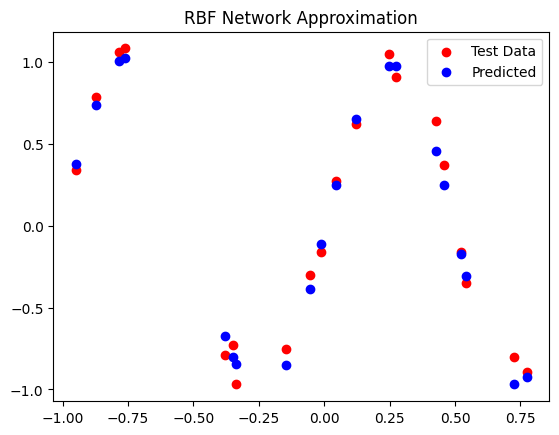

In [ ]:
if __name__ == "__main__":
    # Генерация данных
    np.random.seed(42)
    X = np.random.uniform(-1, 1, (100, 1))
    y = np.sin(2 * np.pi * X) + np.random.normal(0, 0.1, X.shape)

    # Разделение на обучение и тест
    X_train, X_test = X[:80], X[80:]
    y_train, y_test = y[:80], y[80:]

    # Создание и обучение RBF сети
    rbf_net = RBFNetwork(num_centers=10, beta=10)
    rbf_net.fit(X_train, y_train)
    y_pred = rbf_net.predict(X_test)

    # Визуализация
    plt.scatter(X_test, y_test, label="Test Data", color="red")
    plt.scatter(X_test, y_pred, label="Predicted", color="blue")
    plt.legend()
    plt.title("RBF Network Approximation")
    plt.show()

#Демонстрация работы RBF-функций
Добавить визуализацию RBF-функций: Демонстрация того, как выглядят радиально-базисные функции для каждого центра. Это поможет зрителям понять, как каждая RBF реагирует на входные данные.

## Визуализация радиально-базисных функций (RBF)

### Формула радиально-базисной функции (Гауссовой функции):


$ϕ(x) = \exp\left(-\beta \|x - c\|^2 \right)$


где:  
- $\phi(x)$ — значение радиально-базисной функции в точке \( x \).  
- $\ c \$ — центр RBF-функции (центроид, найденный методом K-Means).

- $\beta$— коэффициент, регулирующий ширину функции.  
- $\|x - c\|^2 $ — евклидово расстояние между входным значением \( x \) и центром \( c \).  



### Генерация RBF-функций для визуализации

Мы строим радиально-базисные функции для каждого найденного центра.  
График ниже показывает, как разные RBF-функции "реагируют" на входные данные.

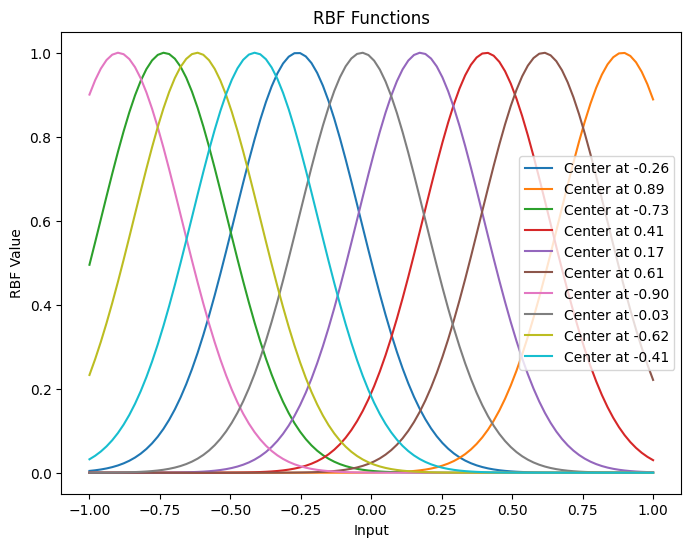

In [ ]:
X_range = np.linspace(-1, 1, 100).reshape(-1, 1)
rbf_net.plot_rbf_functions(X_range)

#Пошаговое объяснение процесса обучения
Визуализировать центры, найденные KMeans, и соответствующие им радиусы действия (ширина RBF).
Накладывать RBF-функции на данные, чтобы показать, как они "накрывают" пространство данных.

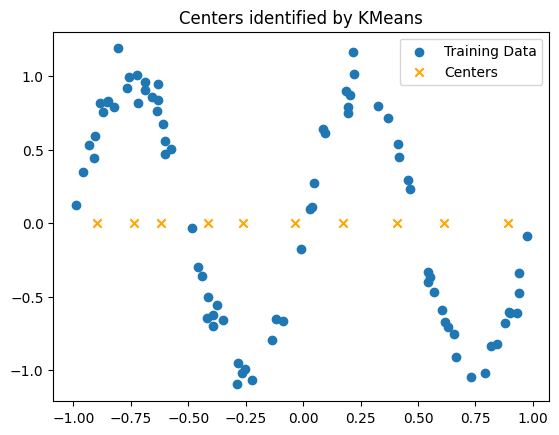

In [ ]:
# Визуализация центров
plt.scatter(X_train, y_train, label="Training Data")
plt.scatter(rbf_net.centers, np.zeros_like(rbf_net.centers), color='orange', label="Centers", marker='x')
plt.title("Centers identified by KMeans")
plt.legend()
plt.show()

#Интерактивные графики
Чтобы добавить интерактивность:

Добавим возможность польователям изменять параметры, такие как num_centers или beta, и наблюдать за изменениями в реальном времени.

In [ ]:
from ipywidgets import interact

def visualize_rbf_network(num_centers, beta):
    rbf_net = RBFNetwork(num_centers=num_centers, beta=beta)
    rbf_net.fit(X_train, y_train)
    y_pred = rbf_net.predict(X_test)

    plt.scatter(X_test, y_test, label="Test Data", color="red")
    plt.scatter(X_test, y_pred, label="Predicted", color="blue")
    plt.legend()
    plt.title(f"RBF Network Approximation (centers={num_centers}, beta={beta})")
    plt.show()

interact(visualize_rbf_network, num_centers=(2, 20), beta=(1, 20, 0.5))


interactive(children=(IntSlider(value=11, description='num_centers', max=20, min=2), FloatSlider(value=10.0, d…

<function __main__.visualize_rbf_network(num_centers, beta)>

#Ошибки и метрики
Расчет ошибок, таких как:

Среднеквадратичная ошибка (MSE)
Коэффициент детерминации (R²)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}, R²: {r2:.4f}")


MSE: 0.0075, R²: 0.9853


#Сравнение с другими моделями
Сравнение RBFNN с другими моделями (например, линейной регрессией или полиномиальной регрессией).

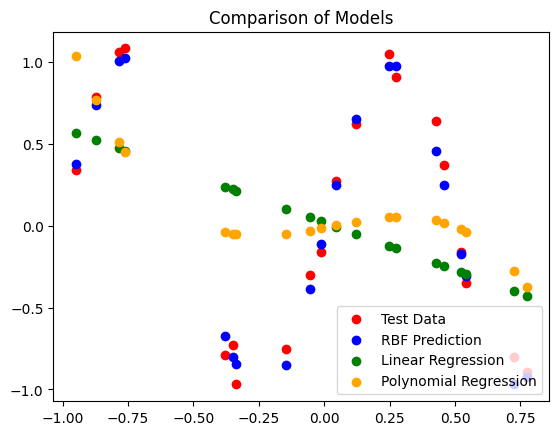

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Линейная регрессия
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Полиномиальная регрессия
poly = PolynomialFeatures(degree=3)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)
lr_poly = LinearRegression()
lr_poly.fit(X_poly_train, y_train)
y_pred_poly = lr_poly.predict(X_poly_test)

# Визуализация
plt.scatter(X_test, y_test, label="Test Data", color="red")
plt.scatter(X_test, y_pred, label="RBF Prediction", color="blue")
plt.scatter(X_test, y_pred_lr, label="Linear Regression", color="green")
plt.scatter(X_test, y_pred_poly, label="Polynomial Regression", color="orange")
plt.legend()
plt.title("Comparison of Models")
plt.show()


## 1️⃣ Добавить многомерные данные  

Сейчас у нас одномерный случай, но RBF-сети работают и в многомерных пространствах. Например, можно взять двумерную функцию:  


$ f(x,y) = \sin(2\pi x) \cos(2\pi y)$


и использовать двумерный ввод $X = (x, y)$.  

### Реализация:
```python
X = np.random.uniform(-1, 1, (100, 2))  # Двумерные входные данные
y = np.sin(2 * np.pi * X[:, 0]) * np.cos(2 * np.pi * X[:, 1]) + np.random.normal(0, 0.1, X.shape[0])


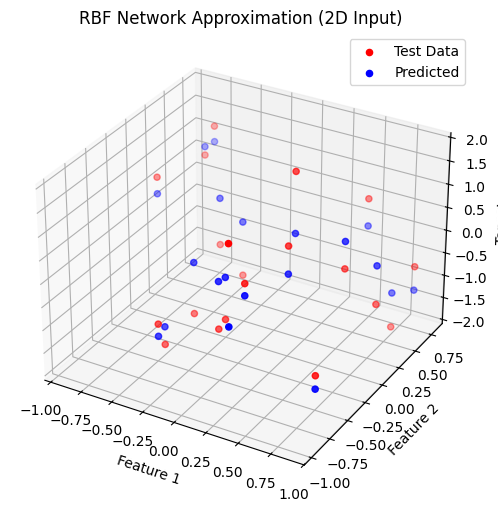

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Для 3D графиков

class RBFNetwork:
    def __init__(self, num_centers, beta=1.0):
        self.num_centers = num_centers
        self.beta = beta  # Ширина гауссовой функции
        self.centers = None
        self.weights = None

    def _rbf(self, x, c):
        """Гауссова RBF для многомерных входов"""
        return np.exp(-self.beta * np.linalg.norm(x - c, axis=1) ** 2)

    def _calculate_interpolation_matrix(self, X):
        """Формируем матрицу интерполяции RBF"""
        G = np.zeros((X.shape[0], self.num_centers))
        for j, c in enumerate(self.centers):
            G[:, j] = self._rbf(X, c)
        return G

    def fit(self, X, y):
        """Обучение RBF сети"""
        kmeans = KMeans(n_clusters=self.num_centers)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        G = self._calculate_interpolation_matrix(X)
        self.weights = np.linalg.pinv(G).dot(y)

    def predict(self, X):
        """Прогнозирование"""
        G = self._calculate_interpolation_matrix(X)
        return G.dot(self.weights)

# --- Генерация многомерных данных ---
np.random.seed(42)
X = np.random.uniform(-1, 1, (100, 2))  # Теперь 2D (двумерные входные данные)
y = np.sin(2 * np.pi * X[:, 0]) + np.cos(2 * np.pi * X[:, 1]) + np.random.normal(0, 0.1, X.shape[0])

X_train, X_test = X[:80], X[80:]
y_train, y_test = y[:80], y[80:]

# --- Обучение сети на многомерных данных ---
rbf_net = RBFNetwork(num_centers=10, beta=10)
rbf_net.fit(X_train, y_train)
y_pred = rbf_net.predict(X_test)

# --- Визуализация ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1], y_test, label="Test Data", color="red")
ax.scatter(X_test[:, 0], X_test[:, 1], y_pred, label="Predicted", color="blue")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Target")
ax.legend()
plt.title("RBF Network Approximation (2D Input)")
plt.show()


## 2️⃣ Добавить разрывные функции  

Сейчас мы используем непрерывную функцию, но RBF-сети могут аппроксимировать и разрывные функции. Например, можно задать кусочно-заданную функцию:  

$
f(x) =
\begin{cases}
\sin(2\pi x), & x \geq 0 \\
\cos(2\pi y), & x < 0
\end{cases}$

### Реализация:
```python
def piecewise_function(x):
    return np.where(x < 0, np.sin(2 * np.pi * x), np.cos(2 * np.pi * x))

X = np.random.uniform(-1, 1, (100, 1)) # Одномерные входные данные
y = piecewise_function(X) + np.random.normal(0, 0.1, X.shape) # Разрывная функция с шумом



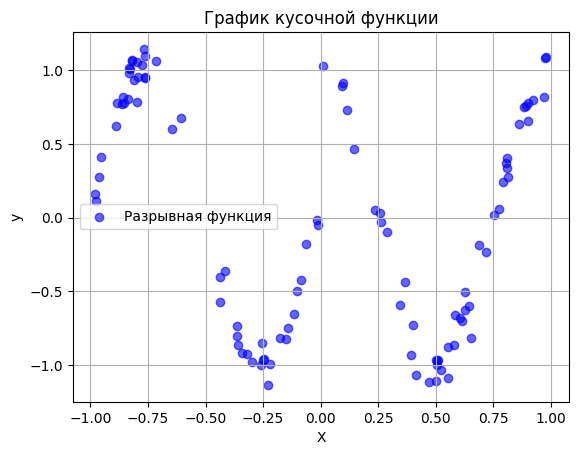

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Определение кусочной функции с разрывами
def piecewise_function(x):
    return np.where(x < 0, np.sin(2 * np.pi * x), np.cos(2 * np.pi * x))

# Генерация входных данных
X = np.random.uniform(-1, 1, (100, 1))

# Вычисление значений целевой функции с добавлением шума
y = piecewise_function(X) + np.random.normal(0, 0.1, X.shape)

# Визуализация данных
plt.scatter(X, y, label="Разрывная функция", color="b", alpha=0.6)
plt.xlabel("X")
plt.ylabel("y")
plt.title("График кусочной функции")
plt.legend()
plt.grid()
plt.show()


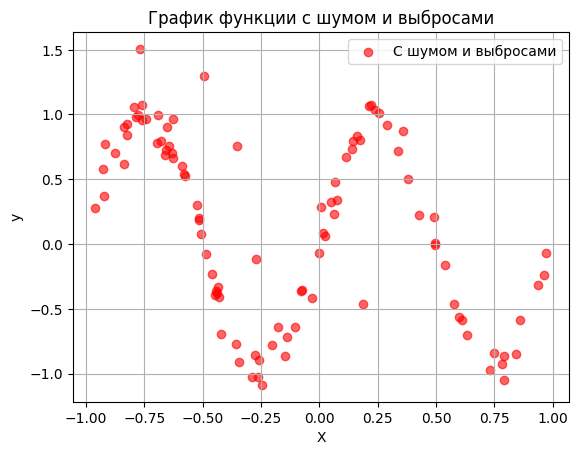

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Определение функции с выбросами
def target_function(x):
    return np.sin(2 * np.pi * x)

# Генерация входных данных
X = np.random.uniform(-1, 1, (100, 1))

# Вычисление целевой функции с добавлением нормального шума
y = target_function(X) + np.random.normal(0, 0.1, X.shape)

# Добавление выбросов (5 случайных точек с большим отклонением)
num_outliers = 5
outlier_indices = np.random.choice(len(X), num_outliers, replace=False)
y[outlier_indices] += np.random.uniform(-2, 2, (num_outliers, 1))  # Добавляем сильные выбросы

# Визуализация данных
plt.scatter(X, y, label="С шумом и выбросами", color="r", alpha=0.6)
plt.xlabel("X")
plt.ylabel("y")
plt.title("График функции с шумом и выбросами")
plt.legend()
plt.grid()
plt.show()


# NEW Version

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.cluster import KMeans

class RBFNetwork:
    def __init__(self, n_centers, sigma=1.0, learning_rate=0.01, max_epochs=100):
        """
        Инициализация радиально-базисной сети

        Параметры:
        - n_centers: количество центров (нейронов скрытого слоя)
        - sigma: ширина радиальных функций
        - learning_rate: скорость обучения
        - max_epochs: максимальное число эпох обучения
        """
        self.n_centers = n_centers
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.centers = None
        self.weights = None
        self.training_history = []

    def _gaussian(self, distances):
        """
        Радиальная базисная функция (гауссиана)
        """
        return np.exp(-0.5 * (distances / self.sigma) ** 2)

    def _calculate_activations(self, X):
        """
        Вычисляет активации скрытого слоя
        """
        distances = cdist(X, self.centers)
        return self._gaussian(distances)

    def fit(self, X, y, animate=False):
        """
        Обучение сети на данных

        Параметры:
        - X: входные данные, матрица размера (n_samples, n_features)
        - y: целевые значения, вектор размера (n_samples,)
        - animate: если True, сохраняет историю для анимации
        """
        # Инициализация центров с помощью K-means
        kmeans = KMeans(n_clusters=self.n_centers, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        # Инициализация весов выходного слоя
        self.weights = np.random.randn(self.n_centers)

        # История обучения для анимации
        if animate:
            self.training_history = []
            self.training_history.append({
                'centers': self.centers.copy(),
                'weights': self.weights.copy()
            })

        # Обучение
        for epoch in range(self.max_epochs):
            # Прямой проход
            hidden_activations = self._calculate_activations(X)
            predictions = hidden_activations @ self.weights

            # Ошибка
            error = y - predictions
            mse = np.mean(error ** 2)

            # Обновление весов (градиентный спуск)
            delta_weights = self.learning_rate * hidden_activations.T @ error
            self.weights += delta_weights

            # Обновление центров (необязательно, но часто используется)
            for i in range(self.n_centers):
                # Вычисляем влияние каждого центра на общую ошибку
                activations = hidden_activations[:, i].reshape(-1, 1)
                delta_centers = self.learning_rate * np.sum(
                    (error * self.weights[i]).reshape(-1, 1) * activations *
                    (X - self.centers[i]) / (self.sigma ** 2), axis=0
                )
                self.centers[i] += delta_centers

            if animate and epoch % 5 == 0:  # Сохраняем каждую 5-ю эпоху для экономии памяти
                self.training_history.append({
                    'centers': self.centers.copy(),
                    'weights': self.weights.copy(),
                    'mse': mse
                })

            # Досрочная остановка при достижении малой ошибки
            if mse < 1e-6:
                break

        return self

    def predict(self, X):
        """
        Предсказание значений для новых данных
        """
        hidden_activations = self._calculate_activations(X)
        return hidden_activations @ self.weights

    def visualize_rbf_functions(self, X_range, feature_names=None):
        """
        Визуализирует радиальные базисные функции на заданном диапазоне X
        """
        if X_range.shape[1] > 2:
            print("Визуализация возможна только для 1D или 2D данных")
            return

        if X_range.shape[1] == 1:
            # 1D случай
            plt.figure(figsize=(10, 6))
            x = X_range.flatten()

            # Активации каждого RBF-нейрона
            for i, center in enumerate(self.centers):
                distances = np.abs(x - center.item())
                activations = self._gaussian(distances)
                plt.plot(x, activations, label=f'RBF {i+1}')
                plt.axvline(center.item(), color='r', linestyle='--', alpha=0.3)

            # Результирующая функция
            activations = self._calculate_activations(X_range)
            output = activations @ self.weights
            plt.plot(x, output, 'k--', linewidth=2, label='Выход сети')

            plt.xlabel(feature_names[0] if feature_names else 'X')
            plt.ylabel('Активация')
            plt.title('Радиальные базисные функции')
            plt.legend()
            plt.grid(True)
            plt.show()

        else:
            # 2D случай - визуализация через контурные графики
            from matplotlib import cm

            x_min, x_max = X_range[:, 0].min(), X_range[:, 0].max()
            y_min, y_max = X_range[:, 1].min(), X_range[:, 1].max()

            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                                 np.linspace(y_min, y_max, 100))

            grid_points = np.c_[xx.ravel(), yy.ravel()]

            # Создаем сетку из графиков
            fig, axes = plt.subplots(int(np.sqrt(self.n_centers)) + 1,
                                     int(np.sqrt(self.n_centers)) + 1,
                                     figsize=(15, 15))
            axes = axes.flatten()

            # Визуализация каждого RBF-нейрона
            for i, center in enumerate(self.centers):
                if i >= len(axes):
                    break

                # Вычисляем активации для данного нейрона
                distances = np.sqrt(((grid_points - center) ** 2).sum(axis=1))
                z = self._gaussian(distances).reshape(xx.shape)

                # Строим контурный график
                im = axes[i].contourf(xx, yy, z, cmap=cm.viridis)
                axes[i].scatter(center[0], center[1], color='red', s=50, marker='x')
                axes[i].set_title(f'RBF {i+1}')
                axes[i].set_xlabel(feature_names[0] if feature_names else 'X1')
                axes[i].set_ylabel(feature_names[1] if feature_names else 'X2')

            # Визуализация общего выхода сети
            activations = self._calculate_activations(grid_points)
            z_output = (activations @ self.weights).reshape(xx.shape)

            if i+1 < len(axes):
                im = axes[i+1].contourf(xx, yy, z_output, cmap=cm.viridis)
                axes[i+1].scatter(self.centers[:, 0], self.centers[:, 1],
                                 color='red', s=50, marker='x')
                axes[i+1].set_title('Общий выход сети')

            plt.tight_layout()
            plt.show()

    def animate_training(self, X, y, interval=200):
        """
        Создает анимацию процесса обучения
        """
        if not self.training_history:
            print("Нет истории обучения. Запустите fit с параметром animate=True")
            return

        fig, ax = plt.subplots(figsize=(10, 6))

        if X.shape[1] == 1:
            # 1D случай
            scatter = ax.scatter(X, y, alpha=0.6, label='Обучающие точки')
            line, = ax.plot([], [], 'r-', label='Предсказание')
            centers, = ax.plot([], [], 'kx', markersize=10, label='Центры')

            ax.set_xlim(X.min() - 0.5, X.max() + 0.5)
            ax.set_ylim(y.min() - 0.5, y.max() + 0.5)
            ax.legend()
            ax.grid(True)
            ax.set_title('Обучение RBF-сети')

            # Текст для отображения эпохи и MSE
            epoch_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

            # Создаем X для гладкой кривой предсказания
            X_smooth = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

            def update(frame):
                # Обновляем веса и центры
                centers_pos = self.training_history[frame]['centers']
                weights = self.training_history[frame]['weights']

                # Устанавливаем текущие значения для предсказания
                self.centers = centers_pos
                self.weights = weights

                # Предсказание на гладкой кривой
                y_pred = self.predict(X_smooth)

                # Обновляем графики
                line.set_data(X_smooth.flatten(), y_pred)
                centers.set_data(centers_pos.flatten(), [y.min() - 0.3] * len(centers_pos))

                # Обновляем текст с информацией
                mse = self.training_history[frame].get("mse", "N/A")
                if mse != "N/A":
                    epoch_text.set_text(f'Эпоха: {frame*5}, MSE: {mse:.6f}')
                else:
                    epoch_text.set_text(f'Эпоха: {frame*5}, MSE: {mse}')

                return line, centers, epoch_text

        else:
            # 2D случай (упрощенный для наглядности)
            scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.6)
            centers = ax.scatter([], [], color='red', s=100, marker='x', label='Центры')

            ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
            ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
            ax.legend()
            ax.grid(True)
            ax.set_title('Обучение RBF-сети')

            # Текст для отображения эпохи и MSE
            epoch_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

            def update(frame):
                # Обновляем центры
                centers_pos = self.training_history[frame]['centers']

                # Обновляем график
                centers.set_offsets(centers_pos)

                # Обновляем текст с информацией
                mse = self.training_history[frame].get("mse", "N/A")
                if mse != "N/A":
                    epoch_text.set_text(f'Эпоха: {frame*5}, MSE: {mse:.6f}')
                else:
                    epoch_text.set_text(f'Эпоха: {frame*5}, MSE: {mse}')

                return centers, epoch_text

        # Создаем анимацию
        ani = FuncAnimation(fig, update, frames=len(self.training_history),
                            interval=interval, blit=True)

        plt.tight_layout()
        return ani

def experiment_with_rbf(X, y, n_centers_list, sigma_list, X_test=None, y_test=None):
    """
    Проводит эксперименты с разными параметрами RBF-сети

    Параметры:
    - X, y: обучающие данные
    - n_centers_list: список количества центров для тестирования
    - sigma_list: список значений сигмы для тестирования
    - X_test, y_test: тестовые данные (необязательно)

    Возвращает:
    - DataFrame с результатами экспериментов
    """
    import pandas as pd

    results = []

    for n_centers in n_centers_list:
        for sigma in sigma_list:
            # Создаем и обучаем модель
            model = RBFNetwork(n_centers=n_centers, sigma=sigma)
            model.fit(X, y)

            # Вычисляем ошибки
            train_pred = model.predict(X)
            train_mse = np.mean((train_pred - y) ** 2)

            result = {
                'n_centers': n_centers,
                'sigma': sigma,
                'train_mse': train_mse
            }

            # Если есть тестовые данные
            if X_test is not None and y_test is not None:
                test_pred = model.predict(X_test)
                test_mse = np.mean((test_pred - y_test) ** 2)
                result['test_mse'] = test_mse

            results.append(result)

    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)
    return results_df

def visualize_experiment_results(results_df, test_data_available=False):
    """
    Визуализирует результаты экспериментов
    """
    n_centers_list = sorted(results_df['n_centers'].unique())
    sigma_list = sorted(results_df['sigma'].unique())

    # Создаем фигуру
    fig, ax = plt.subplots(1, 2 if test_data_available else 1, figsize=(16, 8 if test_data_available else 6))

    if not test_data_available:
        ax = [ax]

    # График зависимости ошибки от количества центров
    for sigma in sigma_list:
        subset = results_df[results_df['sigma'] == sigma]
        ax[0].plot(subset['n_centers'], subset['train_mse'], 'o-', label=f'sigma={sigma}')

    ax[0].set_xlabel('Количество центров')
    ax[0].set_ylabel('MSE на обучающей выборке')
    ax[0].set_title('Зависимость ошибки от количества центров')
    ax[0].legend()
    ax[0].grid(True)

    if test_data_available:
        # График сравнения ошибок на обучающей и тестовой выборках
        for sigma in sigma_list:
            subset = results_df[results_df['sigma'] == sigma]
            ax[1].plot(subset['n_centers'], subset['train_mse'], 'o-', label=f'train, sigma={sigma}')
            ax[1].plot(subset['n_centers'], subset['test_mse'], 'x--', label=f'test, sigma={sigma}')

        ax[1].set_xlabel('Количество центров')
        ax[1].set_ylabel('MSE')
        ax[1].set_title('Сравнение обучающей и тестовой ошибок')
        ax[1].legend()
        ax[1].grid(True)

    plt.tight_layout()
    plt.show()

def generate_demo_data(n_samples=100, noise=0.1, func_type='sin'):
    """
    Генерирует демонстрационные данные для RBF-сети

    Параметры:
    - n_samples: количество точек данных
    - noise: уровень шума
    - func_type: тип функции ('sin', 'exp', 'complex')

    Возвращает:
    - X: входные данные
    - y: целевые значения
    """
    if func_type == 'sin':
        X = np.linspace(-5, 5, n_samples).reshape(-1, 1)
        y = np.sin(X.flatten()) + noise * np.random.randn(n_samples)
    elif func_type == 'exp':
        X = np.linspace(-2, 2, n_samples).reshape(-1, 1)
        y = np.exp(-X.flatten()**2) + noise * np.random.randn(n_samples)
    elif func_type == '2d':
        # 2D данные для регрессии
        from sklearn.datasets import make_friedman2
        X, y = make_friedman2(n_samples=n_samples, noise=noise, random_state=42)
        # Ограничиваем до первых двух признаков для наглядности
        X = X[:, :2]
    elif func_type == 'classification':
        # 2D данные для классификации
        from sklearn.datasets import make_circles
        X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5, random_state=42)
    else:  # complex
        X = np.linspace(-5, 5, n_samples).reshape(-1, 1)
        y = np.sin(X.flatten()) * np.exp(-0.1 * X.flatten()**2) + noise * np.random.randn(n_samples)

    return X, y

==== Демонстрация работы радиально-базисных нейронных сетей ====
Демонстрация формирования радиальных базисных функций


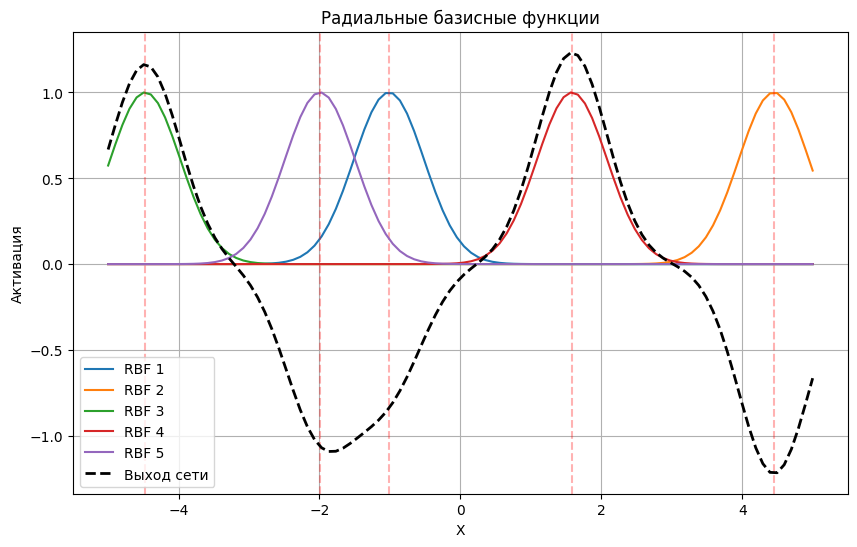

Визуализация в 2D


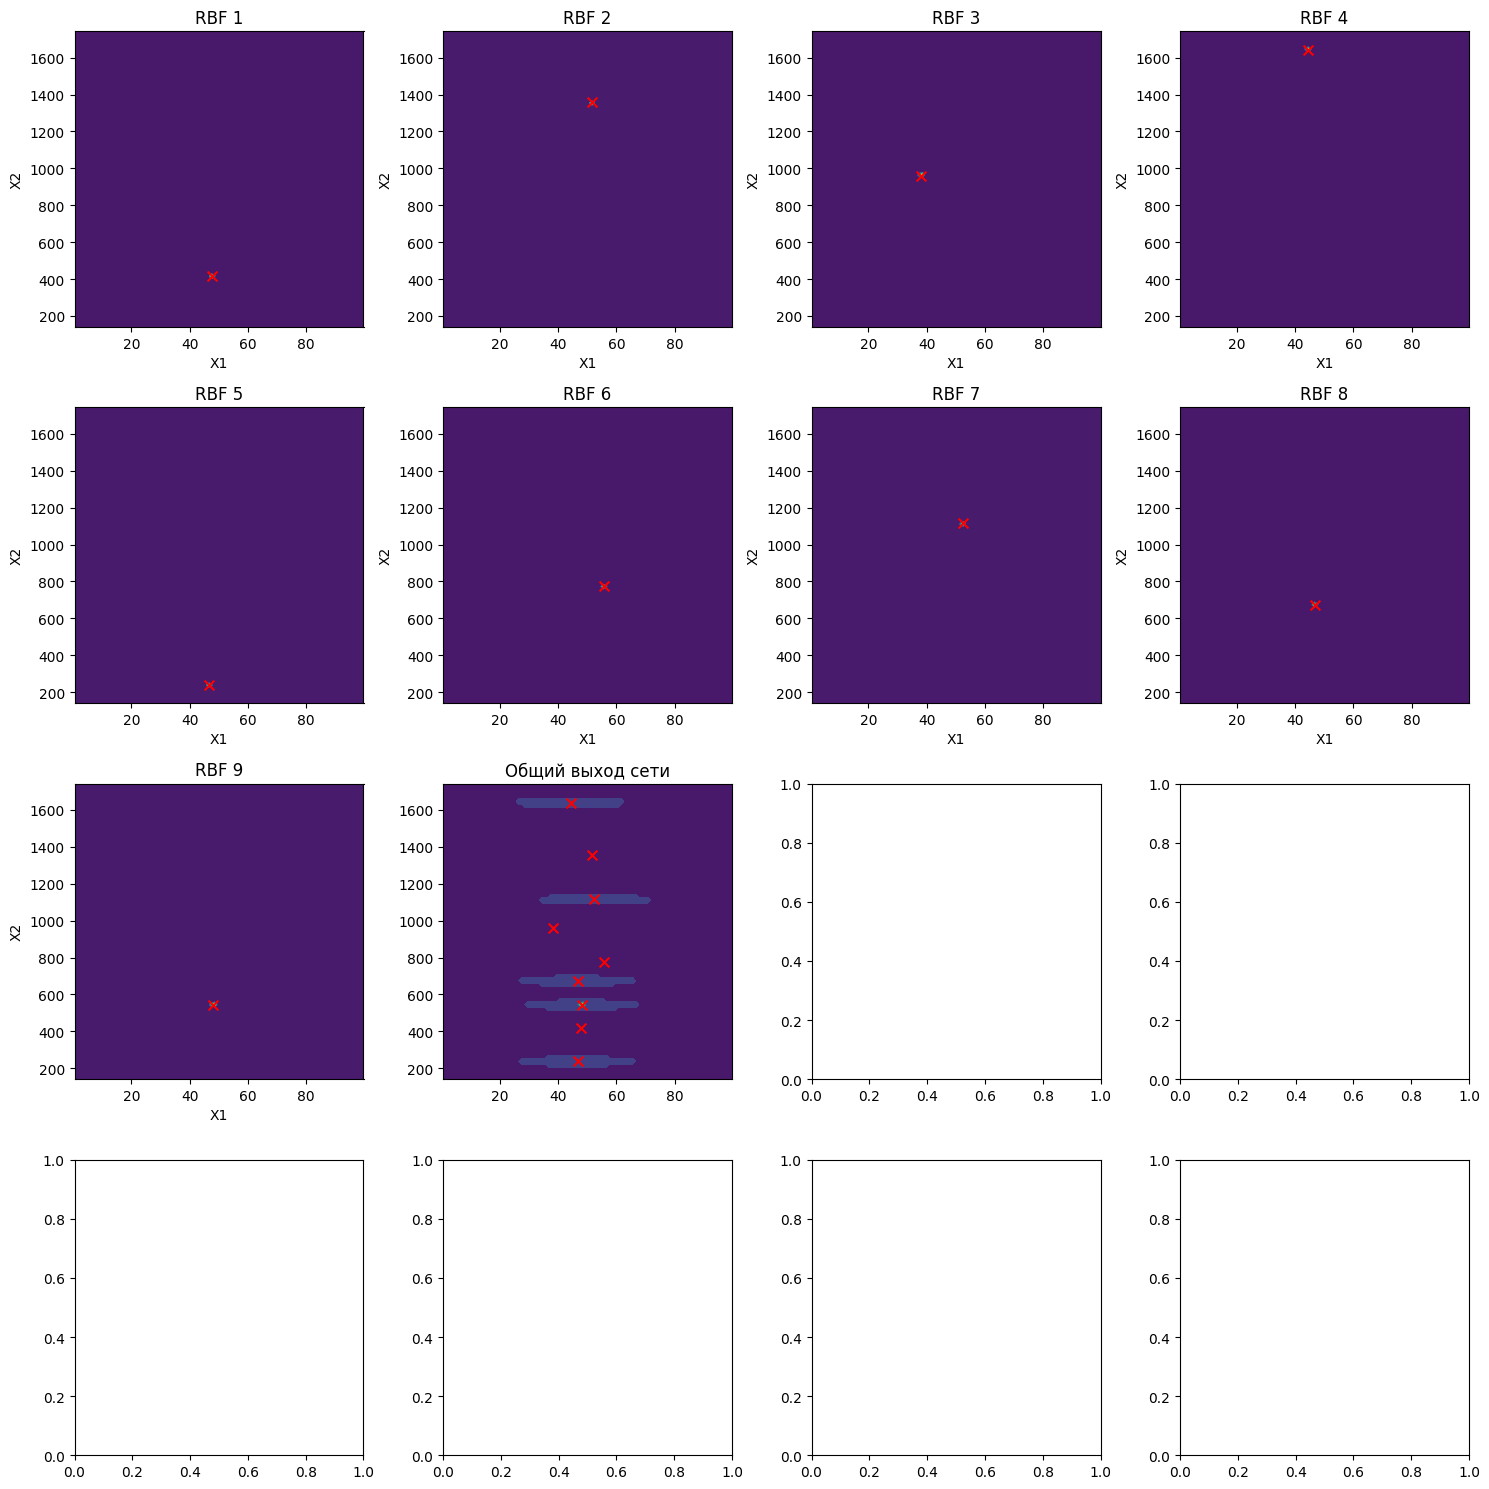

Демонстрация процесса обучения


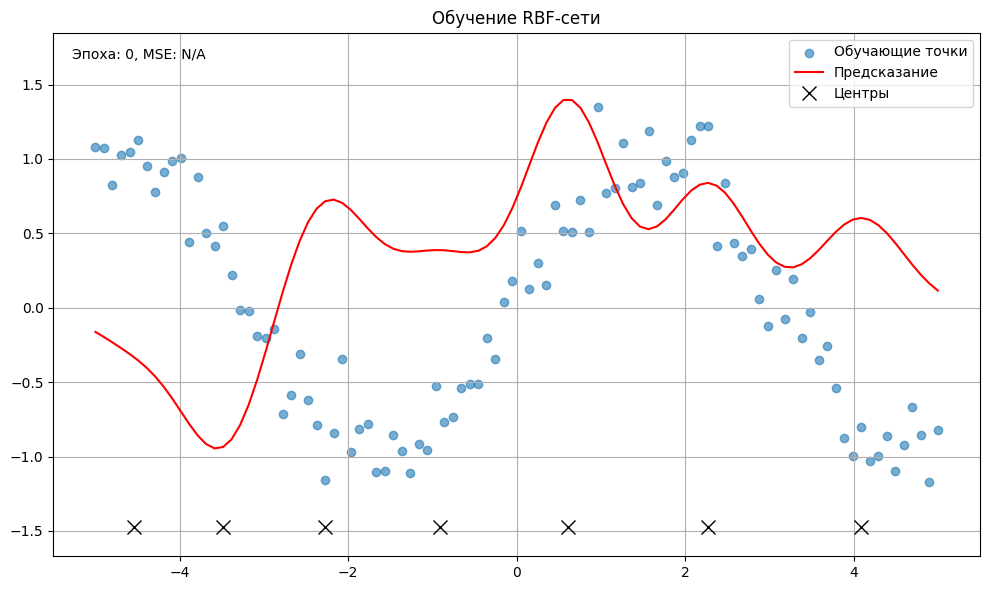

Демонстрация экспериментов с разным количеством нейронов и шириной функций


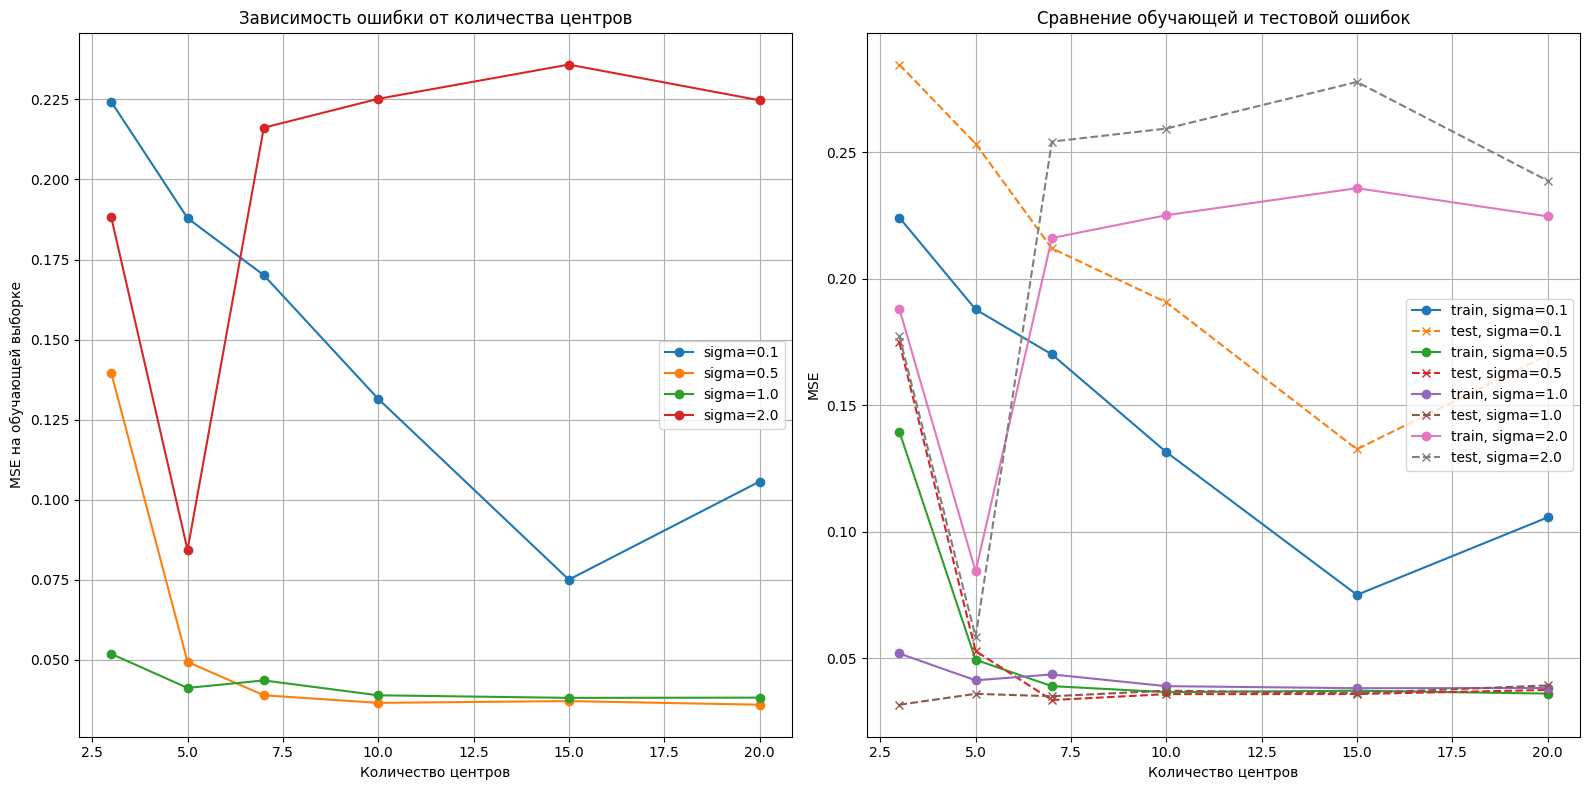


Результаты экспериментов:
    n_centers  sigma  train_mse  test_mse
0           3    0.1   0.224250  0.284734
1           3    0.5   0.139591  0.174911
2           3    1.0   0.051887  0.031633
3           3    2.0   0.188154  0.177365
4           5    0.1   0.187920  0.253444
5           5    0.5   0.049399  0.052858
6           5    1.0   0.041273  0.035935
7           5    2.0   0.084363  0.058442
8           7    0.1   0.170135  0.212075
9           7    0.5   0.038978  0.033476
10          7    1.0   0.043613  0.034984
11          7    2.0   0.216162  0.254278
12         10    0.1   0.131515  0.190727
13         10    0.5   0.036607  0.035815
14         10    1.0   0.038973  0.037185
15         10    2.0   0.225169  0.259428
16         15    0.1   0.075072  0.132636
17         15    0.5   0.037165  0.035859
18         15    1.0   0.038166  0.036196
19         15    2.0   0.235866  0.277864
20         20    0.1   0.105683  0.169850
21         20    0.5   0.036031  0.037466
22     

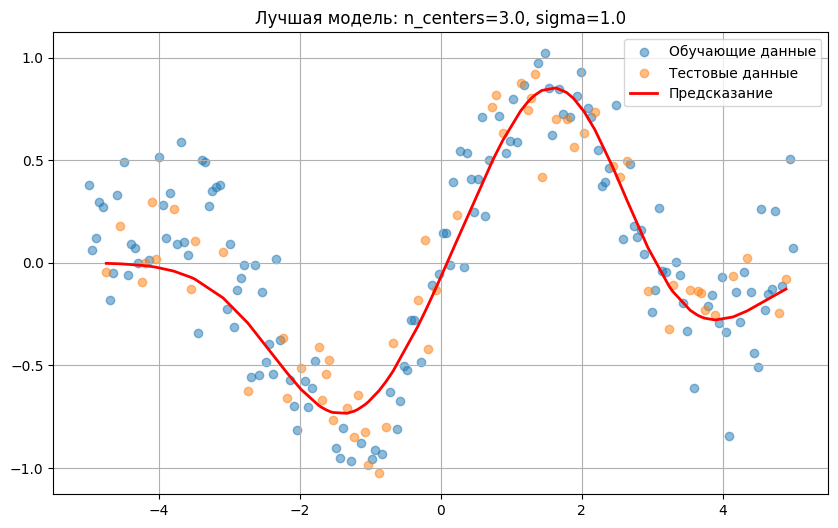

Демонстрация сравнения результатов на разных наборах данных


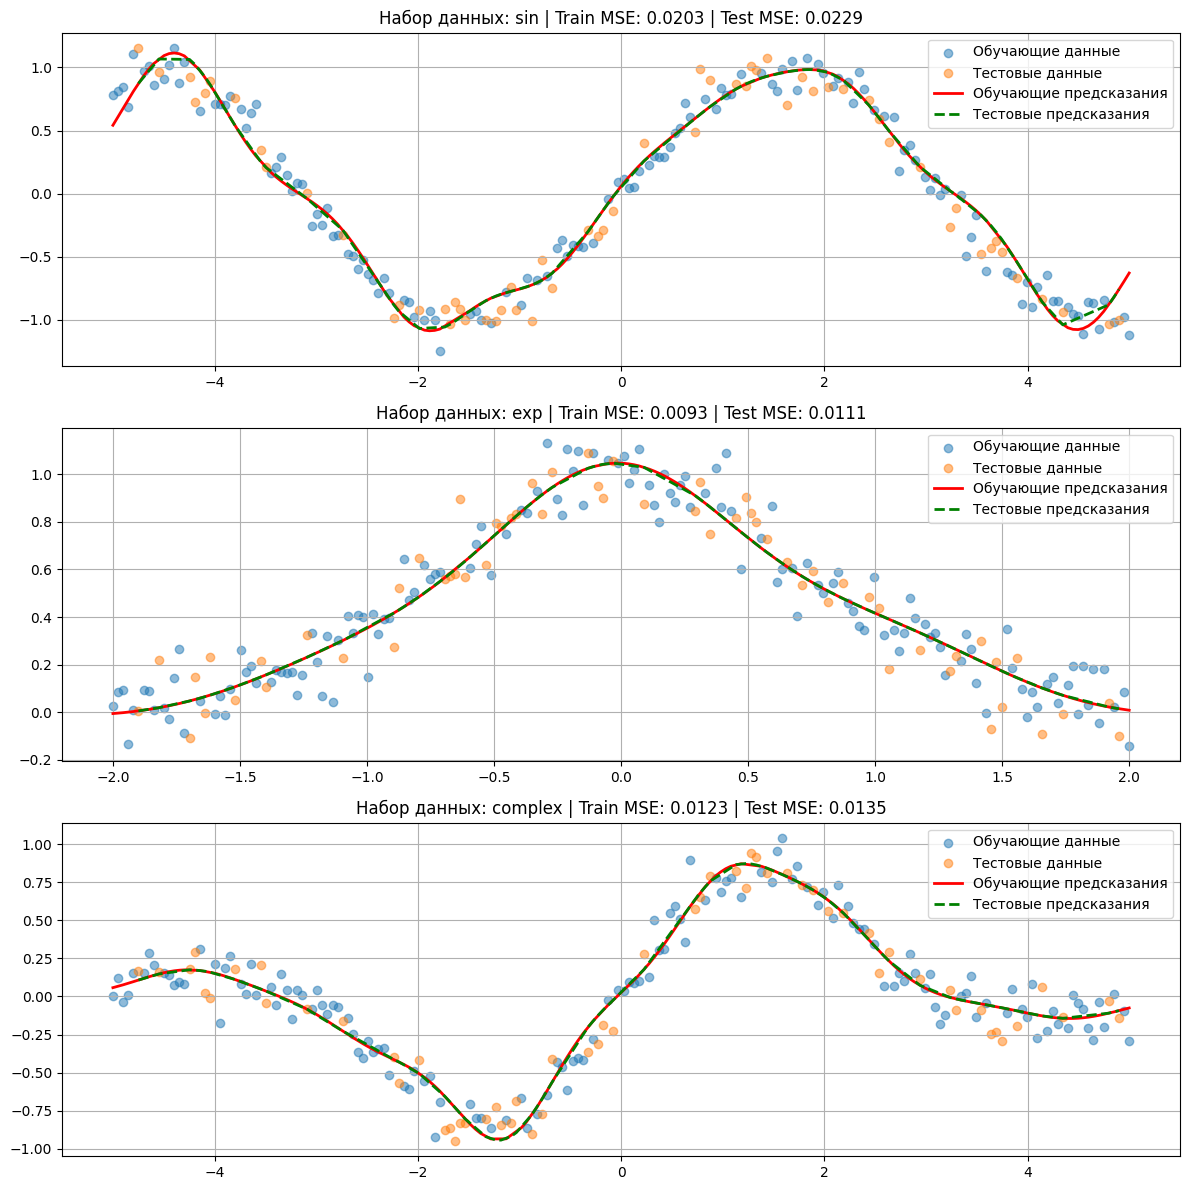

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML
from matplotlib import animation

# Предполагаем, что класс RBFNetwork и вспомогательные функции
# уже импортированы из предыдущего файла

def demo_rbf_formation():
    """
    Демонстрация формирования радиальных базисных функций
    """
    print("Демонстрация формирования радиальных базисных функций")

    # Генерируем простые данные
    X, y = generate_demo_data(n_samples=100, noise=0.1, func_type='sin')

    # Создаем и обучаем модель
    model = RBFNetwork(n_centers=5, sigma=0.5)
    model.fit(X, y)

    # Визуализируем RBF функции
    model.visualize_rbf_functions(X, feature_names=['X'])

    print("Визуализация в 2D")
    # Генерируем 2D данные
    X_2d, y_2d = generate_demo_data(n_samples=200, noise=0.1, func_type='2d')

    # Создаем и обучаем модель
    model_2d = RBFNetwork(n_centers=9, sigma=0.5)
    model_2d.fit(X_2d, y_2d)

    # Визуализируем RBF функции в 2D
    model_2d.visualize_rbf_functions(X_2d, feature_names=['X1', 'X2'])

def demo_training_process():
    """
    Демонстрация процесса обучения
    """
    print("Демонстрация процесса обучения")

    # Генерируем данные
    X, y = generate_demo_data(n_samples=100, noise=0.2, func_type='sin')

    # Создаем и обучаем модель с сохранением истории
    model = RBFNetwork(n_centers=7, sigma=0.5, max_epochs=100)
    model.fit(X, y, animate=True)

    # Создаем анимацию
    ani = model.animate_training(X, y, interval=200)

    # Сохраняем анимацию (опционально)
    # ani.save('rbf_training.mp4', writer='ffmpeg')

    # Отображаем анимацию
    plt.show()

    # Для Jupyter notebook можно использовать:
    # return HTML(ani.to_jshtml())

def demo_experiment_neurons_width():
    """
    Демонстрация экспериментов с разным количеством нейронов и шириной функций
    """
    print("Демонстрация экспериментов с разным количеством нейронов и шириной функций")

    # Генерируем данные
    X, y = generate_demo_data(n_samples=200, noise=0.2, func_type='complex')

    # Разделяем на обучающую и тестовую выборки
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Задаем параметры для экспериментов
    n_centers_list = [3, 5, 7, 10, 15, 20]
    sigma_list = [0.1, 0.5, 1.0, 2.0]

    # Проводим эксперименты
    results = experiment_with_rbf(X_train, y_train, n_centers_list, sigma_list, X_test, y_test)

    # Визуализируем результаты
    visualize_experiment_results(results, test_data_available=True)

    # Выводим таблицу результатов
    print("\nРезультаты экспериментов:")
    print(results)

    # Находим лучшую комбинацию параметров
    best_idx = results['test_mse'].idxmin()
    best_params = results.iloc[best_idx]

    print(f"\nЛучшие параметры: n_centers={best_params['n_centers']}, sigma={best_params['sigma']}")
    print(f"Ошибка на обучающей выборке: {best_params['train_mse']:.6f}")
    print(f"Ошибка на тестовой выборке: {best_params['test_mse']:.6f}")

    # Визуализируем лучшую модель
    print("\nВизуализация лучшей модели:")
    best_model = RBFNetwork(n_centers=int(best_params['n_centers']), sigma=best_params['sigma'])
    best_model.fit(X_train, y_train)

    # Предсказания на тестовой выборке
    y_pred = best_model.predict(X_test)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, y_train, alpha=0.5, label='Обучающие данные')
    plt.scatter(X_test, y_test, alpha=0.5, label='Тестовые данные')

    # Сортируем для корректного отображения линии
    sort_idx = np.argsort(X_test.flatten())
    plt.plot(X_test[sort_idx], y_pred[sort_idx], 'r-', linewidth=2, label='Предсказание')

    plt.title(f'Лучшая модель: n_centers={best_params["n_centers"]}, sigma={best_params["sigma"]}')
    plt.legend()
    plt.grid(True)
    plt.show()

def demo_dataset_comparison():
    """
    Демонстрация сравнения результатов на разных наборах данных
    """
    print("Демонстрация сравнения результатов на разных наборах данных")

    # Генерируем разные наборы данных
    datasets = {
        'sin': generate_demo_data(n_samples=200, noise=0.1, func_type='sin'),
        'exp': generate_demo_data(n_samples=200, noise=0.1, func_type='exp'),
        'complex': generate_demo_data(n_samples=200, noise=0.1, func_type='complex')
    }

    # Параметры модели
    n_centers = 7
    sigma = 0.5

    # Создаем подграфики
    fig, axes = plt.subplots(len(datasets), 1, figsize=(12, 4 * len(datasets)))

    for i, (name, (X, y)) in enumerate(datasets.items()):
        # Разделяем на обучающую и тестовую выборки
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Создаем и обучаем модель
        model = RBFNetwork(n_centers=n_centers, sigma=sigma)
        model.fit(X_train, y_train)

        # Предсказания
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Вычисляем ошибки
        train_mse = np.mean((y_train_pred - y_train) ** 2)
        test_mse = np.mean((y_test_pred - y_test) ** 2)

        # Сортируем для корректного отображения линий
        train_sort_idx = np.argsort(X_train.flatten())
        test_sort_idx = np.argsort(X_test.flatten())

        # Строим график
        ax = axes[i]
        ax.scatter(X_train, y_train, alpha=0.5, label='Обучающие данные')
        ax.scatter(X_test, y_test, alpha=0.5, label='Тестовые данные')
        ax.plot(X_train[train_sort_idx], y_train_pred[train_sort_idx], 'r-',
                linewidth=2, label='Обучающие предсказания')
        ax.plot(X_test[test_sort_idx], y_test_pred[test_sort_idx], 'g--',
                linewidth=2, label='Тестовые предсказания')

        ax.set_title(f'Набор данных: {name} | Train MSE: {train_mse:.4f} | Test MSE: {test_mse:.4f}')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    """
    Главная функция для запуска демонстраций
    """
    print("==== Демонстрация работы радиально-базисных нейронных сетей ====")

    demo_rbf_formation()
    demo_training_process()
    demo_experiment_neurons_width()
    demo_dataset_comparison()

if __name__ == "__main__":
    main()